In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [2]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = sorted(glob(dataset_path + "keras_png_slices_seg_test/*.png"))
seg_train_path = sorted(glob(dataset_path + "keras_png_slices_seg_train/*.png"))
seg_val_path = sorted(glob(dataset_path + "keras_png_slices_seg_validate/*.png"))
test_path = sorted(glob(dataset_path + "keras_png_slices_test/*.png"))
train_path = sorted(glob(dataset_path + "keras_png_slices_train/*.png"))
val_path = sorted(glob(dataset_path + "keras_png_slices_validate/*.png"))

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, seg_train_path))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, seg_val_path))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, seg_test_path))

In [4]:
# Load and process images
train_ds = train_ds.map(dp.process_image)
val_ds = val_ds.map(dp.process_image)
test_ds = test_ds.map(dp.process_image)

In [5]:
test, seg_test = next(iter(test_ds.batch(len(test_path))))

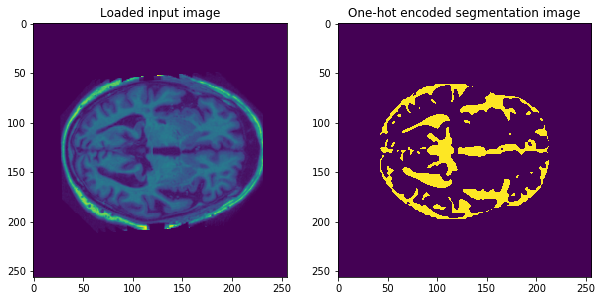

In [6]:
# Display loaded images
def display(title_list, image_list, cmap='viridis'):
    fig, ax = plt.subplots(1, len(title_list), figsize=(10, 10))
    for j, k in enumerate(title_list):
        ax[j].set_title(k)
    for j, k in enumerate(image_list):
        ax[j].imshow(k, cmap=cmap)
        plt.gray()
        
display(["Loaded input image", "One-hot encoded segmentation image"], [test[0][:,:,0], seg_test[0][:,:,1]])

In [8]:
print(np.array(test).shape)
print(np.array(seg_test).shape)

(544, 256, 256, 1)
(544, 256, 256, 4)


In [9]:
# Generate improved unet model
model = iu.unet()

In [10]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])

In [11]:
# Train the model
history = model.fit(train_ds.batch(20), 
                    epochs=8, 
                    validation_data=val_ds.batch(20))

Epoch 1/8
484/484 [==============================] - 203s 419ms/step - loss: 0.0958 - dice_coefficient_avg: 0.8771 - val_loss: 0.0658 - val_dice_coefficient_avg: 0.9268
Epoch 2/8
484/484 [==============================] - 322s 664ms/step - loss: 0.0638 - dice_coefficient_avg: 0.9264 - val_loss: 0.0407 - val_dice_coefficient_avg: 0.9439
Epoch 3/8
484/484 [==============================] - 317s 654ms/step - loss: 0.0378 - dice_coefficient_avg: 0.9539 - val_loss: 0.0422 - val_dice_coefficient_avg: 0.9482
Epoch 4/8
484/484 [==============================] - 218s 451ms/step - loss: 0.0320 - dice_coefficient_avg: 0.9610 - val_loss: 0.0356 - val_dice_coefficient_avg: 0.9563
Epoch 5/8
484/484 [==============================] - 315s 650ms/step - loss: 0.0282 - dice_coefficient_avg: 0.9658 - val_loss: 0.0387 - val_dice_coefficient_avg: 0.9574
Epoch 6/8
484/484 [==============================] - 238s 493ms/step - loss: 0.0259 - dice_coefficient_avg: 0.9686 - val_loss: 0.0346 - val_dice_coefficien

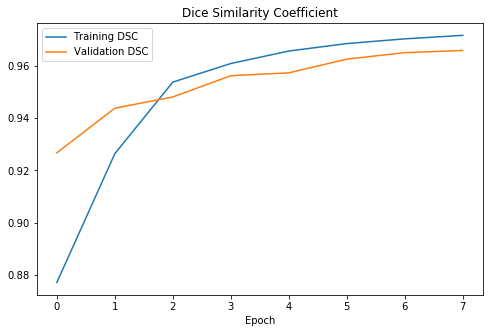

In [12]:
# Plot the training and validation DSC
plt.figure(figsize=(8, 5))
plt.title("Dice Similarity Coefficient")
plt.plot(history.history["dice_coefficient_avg"], label="Training DSC")
plt.plot(history.history["val_dice_coefficient_avg"], label="Validation DSC")
plt.xlabel("Epoch")
plt.legend();
plt.show()

In [13]:
# Calculate DSC
prediction = model.predict(test)
tf.print("Average DSC for all labels: ", iu.dice_coefficient_avg(seg_test, prediction))
tf.print("DSC for each label: ", iu.dice_coefficient(seg_test, prediction))

Average DSC for all labels:  0.967828512
DSC for each label:  [0.957578659 0.957794487 0.960930109 ... 0.970165253 0.970228791 0.969998598]


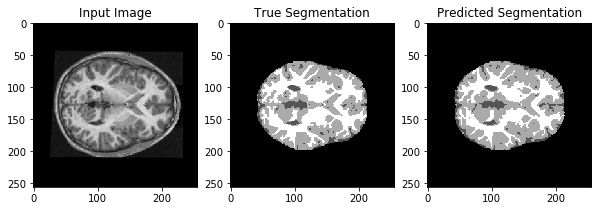

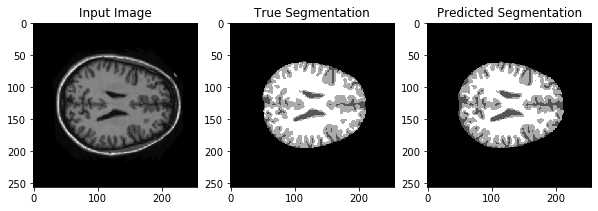

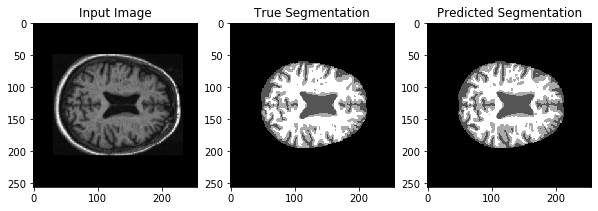

In [19]:
# Display random predictions
random_images = [random.randint(1,len(test)) for i in range(3)]

for i in random_images:
    display(['Input Image', 'True Segmentation', 'Predicted Segmentation'], 
            [test[i][:,:,0], tf.argmax(seg_test[i], axis=-1), tf.argmax(prediction[i], axis=-1)], cmap='gray')